<a href="https://www.kaggle.com/code/aleksandrmorozov123/time-series-forecasting?scriptVersionId=158188716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


**Generating synthetic white noise**

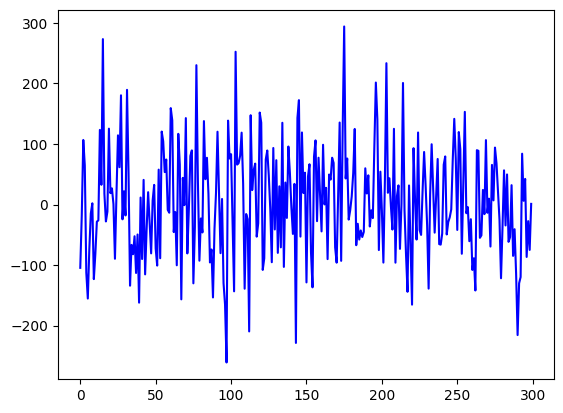

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

time = np.arange (300)
values = np.random.randn (300) * 100

fig, ax = plt.subplots()

ax.plot(time, values, color="blue")

**Red noise** - $ x_{j+1} = r \cdot x_j + (1 - r^2)^{\frac{1}{2}} \cdot w$

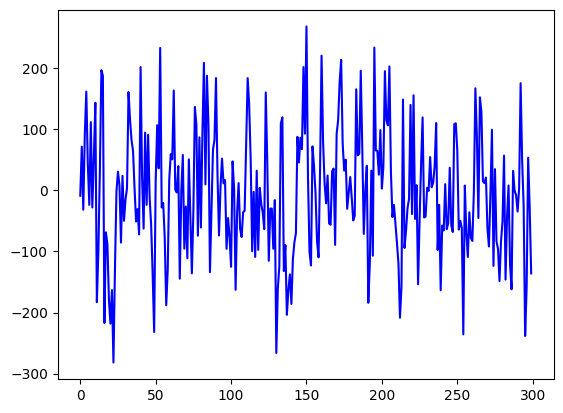

In [3]:
r = 0.4
time = np.arange (300)
white_noise = np.random.randn (300) * 100
values = np.zeros (300)

for i, v in enumerate (white_noise):
    if i == 0:
        values [i] = v
    else:
        values [i] = r*values [i-1] + np.sqrt ((1-np.power (r, 2))) * v

fig, ax = plt.subplots()

ax.plot(time, values, color="blue")

**Create synthetical cyclical time series**

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-yj8c3egt
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-yj8c3egt
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for symengine>=0.4 from https://files.pythonhosted.org/packages/a6/69/97a99ae1835810e0f3f4f471cdfcb6d886be93e4ee5688397deacab955bc/symengine-0.11.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 22.2 MB/s eta 0:00:00
  Created wheel for timesynth: filename=timesynth-0.2.4-py3-none-any.whl size=15422 sha256=b08dc26ac4fa13eefba7b3e84bba40df

Text(0.5, 1.0, 'Irregularly sampled sinusoid with noise')

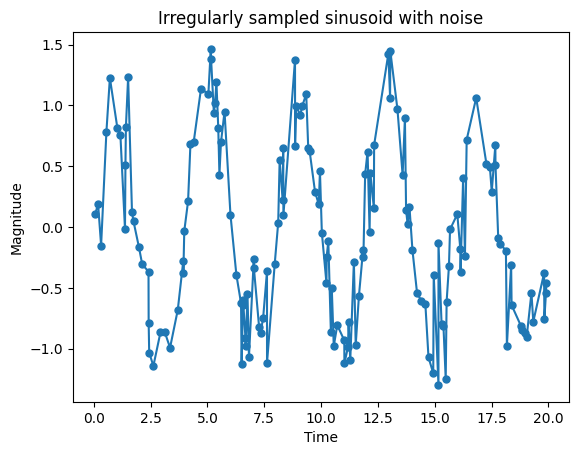

In [4]:
# cite from -  J. R. Maat, A. Malali, and P. Protopapas, 
#“TimeSynth: A Multipurpose Library for Synthetic Time Series in Python,” 2017. 
#[Online]. Available: http://github.com/TimeSynth/TimeSynth
!pip uninstall timesynth --yes
!pip install git+https://github.com/TimeSynth/TimeSynth.git
import timesynth as ts

time_sampler = ts.TimeSampler (stop_time = 20)
irregular_time_samples = time_sampler.sample_irregular_time (num_points = 300,
                                                            keep_percentage = 50)
sinusoid = ts.signals.Sinusoidal (frequency = 0.25)
white_noise = ts.noise.GaussianNoise (std = 0.3)
timeseries = ts.TimeSeries (sinusoid, noise_generator = white_noise)
samples, signals, errors = timeseries.sample (irregular_time_samples)

plt.plot (irregular_time_samples, samples, marker = "o", markersize = 5)
plt.xlabel ("Time")
plt.ylabel ("Magnitude")
plt.title ("Irregularly sampled sinusoid with noise")

**Preparing a real dataset**

In [5]:
df = pd.read_csv ('/kaggle/input/ecommerce-data/data.csv', encoding='ISO-8859-1')
df ['InvoiceDate'] = pd.to_datetime (df ['InvoiceDate'], yearfirst = True)
df.InvoiceDate.min (), df.InvoiceDate.max ()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))